# Pagerank Assignment
Vasileios Dimopoulos

Below we weill create method that produces a sparse Transition Matrix from our Dataframe

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('stanweb.dat',delimiter='\t',header=None)
df

,0,1,2
0,1,6548,0.500000
1,1,15409,0.500000
2,2,252915,0.032258
3,2,246897,0.032258
4,2,251658,0.032258
...,...,...,...
2382907,281903,216688,0.142857
2382908,281903,90591,0.142857
2382909,281903,94440,0.142857
2382910,281903,56088,0.142857


In [3]:
number_nodes = max(df[0].max(),df[1].max())
number_nodes

281903

In [4]:
from scipy.sparse import csr_matrix,identity

def create_sparse_adj_matrix(df, num_nodes):
    rows = []
    cols = []
    data = []

    for index, row in df.iterrows():
        source_node = row[0] - 1  # Adjusting for 0-based indexing
        target_node = row[1] - 1  # Adjusting for 0-based indexing
        weight = row[2]
        
        rows.append(source_node)
        cols.append(target_node)
        data.append(weight)

    adj_matrix = csr_matrix((data, (rows, cols)), shape=(num_nodes, num_nodes))
    return adj_matrix

num_nodes = number_nodes  # Specify the number of nodes
sparse_adj_matrix = create_sparse_adj_matrix(df, num_nodes)

## a) Find the vector π with
### i) the Power method
### ii) solving the corresponding system

## Power Method (a = 0.85)

Initializing hyperparameters a, tolerance, vector a, X0 and v vector for the power method

In [5]:
a = 0.85
stopping_criterion = 10**(-8) 
nodes_with_out_links = df[0].unique()
a_vector = np.ones(number_nodes)
for number in nodes_with_out_links:
    a_vector[number-1] = 0
x_0_T = (np.ones(number_nodes)/number_nodes).T
v = (np.ones(number_nodes)/number_nodes).T

We create a method that iteratively computes αx(k−1)T P + (αx(k−1)T a + (1 − α))vT , as seen in the pagerank paper.

In [6]:
import time

def power_method(M,x,a,a_vector,v,stopping_criterion, max_iterations):
    start_time = time.time()
    for k in range(max_iterations):
        x_old = x
        x = M.T.dot(a*x_old) + (np.dot(a*x_old,a_vector)+(1-a))*v.T
        if np.linalg.norm(x - x_old, 2) < stopping_criterion:
            break
    print(f"Iterations: {k+1}")
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate elapsed time
    print(f"Time taken: {elapsed_time} seconds")  # Print the elapsed time
    return x

In [7]:
# give 10 more iterations from expected 114
p = power_method(sparse_adj_matrix,x_0_T,a,a_vector,v,stopping_criterion, 124)

Iterations: 72
Time taken: 0.5919132232666016 seconds


After 0.6 seconds and 72 iterations the method returned the pagerank vector p.

In [8]:
np.save('pagerank_powers_method_085.npy', p)
print(p)

[5.33366163e-07 1.17178113e-04 8.27158893e-07 ... 5.37022302e-07
 1.80873750e-06 1.47923201e-06]


The top 50 pages node numbers from 50-1 can be seen below

In [9]:
top_50_pm_pagerank = np.argsort(p)[-50:]

print("Indices of top 50 elements:", top_50_pm_pagerank+1)

Indices of top 50 elements: [222873 258348 214128     91 208542  60440  81435 151428 145892 112742
  96745 137632 183004 221087 176790  77999  17781 161890 120708  62478
 259455 247241 181701 132695 235496  60210 198090 117152  38342 179645
 167295  55788 231363 119479 272442 251796  95163 186750 225872  67756
  69358 105607  68889 136821 234704 134832 262860 241454 226411  89073]


## Linear System (a = 0.85), Gauss-Seidel Method

We create a method to produce sparse matrix I-aP.

In [10]:
from scipy.sparse import eye
def subtract_alpha_times_P(P, alpha):
    n = P.shape[0]  # Assuming P is a square matrix
    I = eye(n, format='csr')  # Creating a sparse identity matrix with the same shape as P
    return I - alpha * P
I_minus_aP = subtract_alpha_times_P(sparse_adj_matrix, a)

This method gets aij from a sparse matrix A.

In [11]:
def get_A_ij(csr_matrix,i,j):
    indptr = csr_matrix.indptr
    indices = csr_matrix.indices
    data = csr_matrix.data
    
    start_index = indptr[i]
    end_index = indptr[i+1]
    
    for i in range(start_index, end_index):
        if indices[i] == j:
            return data[i]
    return 0

### Algorithm Gauss–Seidel method is
    inputs: A, b
    output: φ

    Choose an initial guess φ to the solution
    repeat until convergence
        for i from 1 until n do
            σ ← 0
            for j from 1 until n do
                if j ≠ i then
                    σ ← σ + aijφj
                end if
            end (j-loop)
            φi ← (bi − σ) / aii
        end (i-loop)
        check if convergence is reached
    end (repeat)

In [12]:
def gauss_seidel(A, v, tol=stopping_criterion, max_iter=1000):
    start_time = time.time()
    n = A.shape[0]
    x = np.ones(n)/n
    for k in range(max_iter):
        x_old = x
        for i in range(n):
            s = 0
            row_slice = A.getrow(i)
            for j, val in zip(row_slice.indices, row_slice.data):
                if (j != i):
                    s += val*x[j]
            x[i] = (v[i]-s)/get_A_ij(A,i,i)
        if np.linalg.norm(x - x_old, 2) < tol:
            print(f"Iterations: {k+1}")
            break
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate elapsed time
    print(f"Time taken: {elapsed_time} seconds")  # Print the elapsed time
    return x

In [13]:
p = gauss_seidel(I_minus_aP.transpose(), v)

Iterations: 1
Time taken: 2890.9925286769867 seconds


After 1 iteration and 2890 seconds, the method solved the linear system fot I-aP = v and produced the pagerank vector p.

In [14]:
print(p)

[3.54731947e-06 1.81959173e-04 3.97806540e-06 ... 3.57163577e-06
 6.82030354e-06 6.99263416e-06]


In [15]:
top_50_linear_system_pagerank = np.argsort(p)[-50:]

print("Indices of top 50 elements:", top_50_linear_system_pagerank+1)

Indices of top 50 elements: [120708 137632 186902  65463 267492 132695 205477 176790 117152 181701
 183004  68295  93989 221087 235496 134375 247241 278083 259455 262860
  68889 170452 272762  95163 258348 101161 136821 158568  93778  34573
 251796 119479  81435  38342 105607 198090 214128 245659 272442 167295
 234704  67756 186750  69358 225872 231363 134832  89073 241454 226411]


The rankings of the 2 methods semm to differ as well as the significant difference in convergance time, with power method finishing very fast in opposition to the very slow linear system method.

In [16]:
np.save('pagerank_linear_system_085.npy', p)

## b) Do the previous task with α = 0.99. Your remarks on the convergence speed. Did the ranking of the first 50 nodes changed?

## Power Method (a = 0.99)

In [17]:
a = 0.99
p = power_method(sparse_adj_matrix,x_0_T,a,a_vector,v,stopping_criterion,10000)
np.save('pagerank_powers_method_099.npy', p)
print(p)
top_50_pm_pagerank = np.argsort(p)[-50:]

print("Indices of top 50 elements:", top_50_pm_pagerank+1)

Iterations: 1141
Time taken: 9.60521650314331 seconds
[3.61261719e-08 1.04528616e-04 1.30868895e-07 ... 3.64145986e-08
 4.11009438e-07 1.88426140e-07]
Indices of top 50 elements: [236644 144494  58612  49047  85040 264187 234962 169234  95366 229580
  96196 272762  27904 119822  96745  77999  17781 137632 183004 221087
 176790  62478 120708 259455 247241 235496 181701 152337 117152  77084
  14785  58048 245765 241454 119479  65580 272442  95163 251796 116530
  77988  68889 136821 262860 271409 179645 226411 174665 281772  89073]


After executing the power method for a= 0.99 we can see that both the pageranks and the convergance time change. The algorithm needed almost 1000 more iterations and 13x the time to converge from the previous value of a.

## Linear System (a = 0.99), Gauss-Seidel Method

In [18]:
I_minus_aP = subtract_alpha_times_P(sparse_adj_matrix, a)
p = gauss_seidel(I_minus_aP.transpose(), v)
np.save('pagerank_linear_system_099.npy', p)
print(p)
top_50_pm_pagerank = np.argsort(p)[-50:]

print("Indices of top 50 elements:", top_50_pm_pagerank+1)

Iterations: 1
Time taken: 2909.3538916110992 seconds
[3.54731947e-06 2.11344655e-04 4.04901179e-06 ... 3.57564081e-06
 8.03313499e-06 8.00994118e-06]
Indices of top 50 elements: [137632 279368 186902 132695 137798 267492 205477 176790 117152  68295
 181701 183004  93989 134375 235496 221087 278083 247241  68889 259455
  95163 170452 272762 262860 258348 136821  93778  34573 101161 158568
 119479  81435 251796  38342 105607 198090 214128 245659 272442 167295
 234704  67756  69358 186750 225872 231363  89073 134832 241454 226411]


The linear system, produced exactly the same pagerank, at the same time and iterations, despite the change of a.

## c) When we use the power method do all the cmponents of π converge at the same speed to their limits? If not which of the converge faster: those that correspond to important nodes or to non important ? Do you observe the same behavior when you find π through the solution of the linear system?

In [19]:
def power_method_conv(M,x,a,a_vector,v,stopping_criterion, max_iterations):
    n = M.shape[0]
    converged = np.full(n, False)
    rate = np.empty(n)
    start_time = time.time()
    for k in range(max_iterations):
        x_old = x
        x = M.T.dot(a*x_old) + (np.dot(a*x_old,a_vector)+(1-a))*v.T
        delta_array = np.abs(x - x_old)
        for i in range(n):
            if delta_array[i] <stopping_criterion:
                if converged[i] == False:
                    converged[i] = True
                    rate[i] = k+1
        if np.linalg.norm(x - x_old, 2) < stopping_criterion:
            break
    print(f"Iterations: {k+1}")
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate elapsed time
    print(f"Time taken: {elapsed_time} seconds")  # Print the elapsed time
    return rate

In [20]:
a = 0.85
rates = power_method_conv(sparse_adj_matrix,x_0_T,a,a_vector,v,stopping_criterion, 124)

Iterations: 72
Time taken: 12.399399042129517 seconds


In [21]:
rates

array([ 2., 53.,  8., ...,  3., 12., 12.])

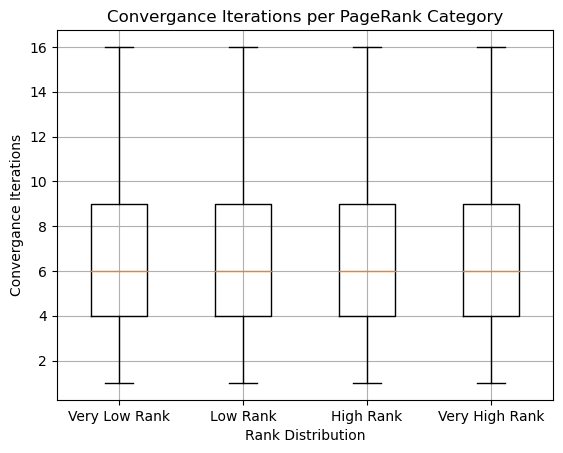

In [22]:
import matplotlib.pyplot as plt
p = np.load('pagerank_powers_method_085.npy')
ranks = np.argsort(p)[::-1] + 1

thresholds = np.percentile(ranks, [25, 50, 75])

# Assign ranks to buckets
bucket_indices = np.digitize(ranks, thresholds)

# Create lists to hold rates for each bucket
bucket_rates = [[] for _ in range(4)]
for i in range(len(ranks)):
    bucket_rates[bucket_indices[i] - 1].append(rates[i])

# Create box plots
plt.boxplot(bucket_rates, labels=["Very Low Rank", "Low Rank", "High Rank", "Very High Rank"],showfliers=False)

# Add labels and title
plt.xlabel('Rank Distribution')
plt.ylabel('Convergance Iterations')
plt.title('Convergance Iterations per PageRank Category')

# Display plot
plt.grid(True)
plt.show()

At the above box plots, we can see the convergance (in iterations) rate of our nodes, for the power method. For 4 rank clusters of nodes we can see no difference in the distribution of convergance rate. We didn't do the same for the linear system method, as it finished in 1 iteration.

## a) You now create a new web page X (thus adding a node to the web graph). X has neither in-links, nor out-links. Let ˜π = (˜π1, π˜2, . . . π˜n) denote the vector of new PageRanks of the n old web pages, and x denote the new PageRank of page X: In other words, (˜π1, π˜2, . . . , π˜n, x) is the PageRank vector of the new web graph. Write ˜π and x in terms of r: Comment on how the PageRanks of the older pages changed due to the addition of the new page (remember n is a very large number). Hint: Use the stationary equations to calculate PageRank, not the iterative approach.

In [23]:
import numpy as np
from scipy.sparse import csr_matrix

def calculate_new_pageranks(old_pageranks, alpha, n):
    # Calculate the redistribution factor
    r = (1 - alpha) / n
    redist_fact = (n-1+alpha)/n
    # Adjust the PageRanks of old pages
    new_pageranks = redist_fact * old_pageranks

    return np.append(new_pageranks,r)

# Example usage
n = number_nodes  # Number of old pages
alpha = 0.85  # Damping factor
old_pageranks = np.load('pagerank_powers_method_085.npy')

new_pageranks = calculate_new_pageranks(old_pageranks, alpha, n)
r = (1 - alpha) / n
pr_in_terms_of_r = new_pageranks/r
print(pr_in_terms_of_r)
print(f"Min: {min(pr_in_terms_of_r)}")
print(f"Max: {max(pr_in_terms_of_r)}")

[  1.00238294 220.21896021   1.554523   ...   3.39925504   2.77999814
   1.        ]
Min: 1.0
Max: 21242.016615019602


In the above method, we adjasted the pageranks of the old pages by scaling them by (n-1+a)/n and we gave the new node a pagerank of r (1-a). We can see that the highest ranked node had a pagerank (in terms of r) 0f 21242 and our new node had the lowest, with 1.

In [24]:
norm_difference = np.linalg.norm(old_pageranks - new_pageranks[:-1])
norm_difference

1.2019447284265002e-08

The difference of the previous with the new pagerank, in l2 norm was the above. We can see that this is a very low number at the ranks of our tolerance level, so the pagerank vector didn't change much by adding X.

In [25]:
new_pageranks[281903]

5.320979202065959e-07

## b) Unsatisfied with the PageRank of your page X; you create another page Y (with no in-links) that links to X: What are the PageRanks of all the n + 2 pages now? Does the PageRank of X improve?

In [26]:
Y = {0: 281905, 1: 281904, 2: 1}
df = df.append(Y, ignore_index=True)
df

C:\Users\vassi\AppData\Local\Temp\ipykernel_9248\1224424834.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(Y, ignore_index=True)


,0,1,2
0,1,6548,0.500000
1,1,15409,0.500000
2,2,252915,0.032258
3,2,246897,0.032258
4,2,251658,0.032258
...,...,...,...
2382908,281903,90591,0.142857
2382909,281903,94440,0.142857
2382910,281903,56088,0.142857
2382911,281903,44103,0.142857


In [27]:
G = create_sparse_adj_matrix(df, 281905)

In [28]:
a = 0.85
number_nodes = max(df[0].max(),df[1].max())
stopping_criterion = 10**(-8) 
nodes_with_out_links = df[0].unique()
a_vector = np.ones(number_nodes)
for number in nodes_with_out_links:
    a_vector[number-1] = 0
x_0_T = (np.ones(number_nodes)/number_nodes).T
v = (np.ones(number_nodes)/number_nodes).T

p = power_method(G,x_0_T,a,a_vector,v,stopping_criterion, 124)

Iterations: 72
Time taken: 0.600449800491333 seconds


In [29]:
np.save('pagerank_b', p)

In [30]:
r = (1 - alpha) / number_nodes
pr_in_terms_of_r = p/r
print(pr_in_terms_of_r)
print(f"Min: {min(pr_in_terms_of_r)}")
print(f"Max: {max(pr_in_terms_of_r)}")

[  1.00238906 220.22030501   1.55453249 ...   2.78001511   1.85441977
   1.00238906]
Min: 1.0023890634435977
Max: 21242.146332336124


In [31]:
p[281903]/r

1.8544197674202034

After adding node Y and pointing it  to X we can see that the ranking in terms of r increased to 1.85 from 1. It is still low but not the current lowest since it's no more a node without connections.

In [32]:
p[281904]/r

1.0023890634435977

## c) Still unsatisfied, you create a third page Z: How should you set up the links on your three pages so as to maximize the PageRank of X?

In [33]:
df

,0,1,2
0,1,6548,0.500000
1,1,15409,0.500000
2,2,252915,0.032258
3,2,246897,0.032258
4,2,251658,0.032258
...,...,...,...
2382908,281903,90591,0.142857
2382909,281903,94440,0.142857
2382910,281903,56088,0.142857
2382911,281903,44103,0.142857


In [34]:
df.iat[2382912, 2] = 1/2
df

,0,1,2
0,1,6548,0.500000
1,1,15409,0.500000
2,2,252915,0.032258
3,2,246897,0.032258
4,2,251658,0.032258
...,...,...,...
2382908,281903,90591,0.142857
2382909,281903,94440,0.142857
2382910,281903,56088,0.142857
2382911,281903,44103,0.142857


In [35]:
Y2 = {0: 281905, 1: 281906, 2: 1/2}
Z1 = {0: 281906, 1: 281904, 2: 1/2}
Z2 = {0: 281906, 1: 281905, 2: 1/2}
X1 = {0: 281904, 1: 281905, 2: 1/2}
X2 = {0: 281904, 1: 281906, 2: 1/2}
df = df.append(Y2, ignore_index=True)
df = df.append(Z1, ignore_index=True)
df = df.append(Z2, ignore_index=True)
df = df.append(X1, ignore_index=True)
df = df.append(X2, ignore_index=True)
df

C:\Users\vassi\AppData\Local\Temp\ipykernel_9248\2904668912.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(Y2, ignore_index=True)
C:\Users\vassi\AppData\Local\Temp\ipykernel_9248\2904668912.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(Z1, ignore_index=True)
C:\Users\vassi\AppData\Local\Temp\ipykernel_9248\2904668912.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(Z2, ignore_index=True)
C:\Users\vassi\AppData\Local\Temp\ipykernel_9248\2904668912.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(X1, ignore_index=True)
C:\Users\vassi\AppData\Local\Temp\ipykernel_

,0,1,2
0,1.0,6548.0,0.500000
1,1.0,15409.0,0.500000
2,2.0,252915.0,0.032258
3,2.0,246897.0,0.032258
4,2.0,251658.0,0.032258
...,...,...,...
2382913,281905.0,281906.0,0.500000
2382914,281906.0,281904.0,0.500000
2382915,281906.0,281905.0,0.500000
2382916,281904.0,281905.0,0.500000


In [36]:
df[0] = df[0].astype(int)
df[1] = df[1].astype(int)
df

,0,1,2
0,1,6548,0.500000
1,1,15409,0.500000
2,2,252915,0.032258
3,2,246897,0.032258
4,2,251658,0.032258
...,...,...,...
2382913,281905,281906,0.500000
2382914,281906,281904,0.500000
2382915,281906,281905,0.500000
2382916,281904,281905,0.500000


In this setup we created a node Z and made X,Y and Z to all point to each other. That way we increase the PageRank of each one beacause it is pointed by higher rank nodes.

In [37]:
G = create_sparse_adj_matrix(df, 281906)
number_nodes = max(df[0].max(),df[1].max())
stopping_criterion = 10**(-8) 
nodes_with_out_links = df[0].unique()
a_vector = np.ones(number_nodes)
for number in nodes_with_out_links:
    a_vector[number-1] = 0
x_0_T = (np.ones(number_nodes)/number_nodes).T
v = (np.ones(number_nodes)/number_nodes).T

p = power_method(G,x_0_T,a,a_vector,v,stopping_criterion, 124)
np.save('pagerank_c', p)
r = (1 - alpha) / number_nodes
pr_in_terms_of_r = p/r
print(pr_in_terms_of_r)
print(f"Min: {min(pr_in_terms_of_r)}")
print(f"Max: {max(pr_in_terms_of_r)}")
print(p[281903]/r)

Iterations: 72
Time taken: 0.6293494701385498 seconds
[  1.00238345 220.21907181   1.55452378 ...   6.68255629   6.68255629
   6.68255629]
Min: 1.0023834501948914
Max: 21242.02737906444
6.682556287515025


Here we can see that our node X got a ranking, in terms of r, of 6.7 an increase from the previous 1.85.

## d) You have one last idea, you add links from your page X to older, popular pages (e.g.: you add a list of ?Useful links? on your page). Does this improve the PageRank of X? Does the answer change if you add links from Y or Z to older, popular pages?

In [38]:
top_50_pm_pagerank = np.argsort(p)[-5:]
top_50_pm_pagerank

array([134831, 262859, 241453, 226410,  89072], dtype=int64)

In [39]:
X1 = {0: 281904, 1: 89072, 2: 1/2}
X2 = {0: 281904, 1: 226410, 2: 1/2}
X3 = {0: 281904, 1: 241453, 2: 1/2}
X4 = {0: 281904, 1: 262859, 2: 1/2}
X5 = {0: 281904, 1: 134831, 2: 1/2}
df = df.append(X1, ignore_index=True)
df = df.append(X2, ignore_index=True)
df = df.append(X3, ignore_index=True)
df = df.append(X4, ignore_index=True)
df = df.append(X5, ignore_index=True)
num = df[df[0] == 281904][2].count()
df.loc[df[0] == 281904, 2] = 1/num
df[0] = df[0].astype(int)
df[1] = df[1].astype(int)
df

C:\Users\vassi\AppData\Local\Temp\ipykernel_9248\3015387900.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(X1, ignore_index=True)
C:\Users\vassi\AppData\Local\Temp\ipykernel_9248\3015387900.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(X2, ignore_index=True)
C:\Users\vassi\AppData\Local\Temp\ipykernel_9248\3015387900.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(X3, ignore_index=True)
C:\Users\vassi\AppData\Local\Temp\ipykernel_9248\3015387900.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(X4, ignore_index=True)
C:\Users\vassi\AppData\Local\Temp\ipykernel_

,0,1,2
0,1,6548,0.500000
1,1,15409,0.500000
2,2,252915,0.032258
3,2,246897,0.032258
4,2,251658,0.032258
...,...,...,...
2382918,281904,89072,0.142857
2382919,281904,226410,0.142857
2382920,281904,241453,0.142857
2382921,281904,262859,0.142857


In [40]:
G = create_sparse_adj_matrix(df, 281906)
number_nodes = max(df[0].max(),df[1].max())
stopping_criterion = 10**(-8) 
nodes_with_out_links = df[0].unique()
a_vector = np.ones(number_nodes)
for number in nodes_with_out_links:
    a_vector[number-1] = 0
x_0_T = (np.ones(number_nodes)/number_nodes).T
v = (np.ones(number_nodes)/number_nodes).T

p = power_method(G,x_0_T,a,a_vector,v,stopping_criterion, 124)
r = (1 - alpha) / number_nodes
pr_in_terms_of_r = p/r
print(pr_in_terms_of_r)
print(f"Min: {min(pr_in_terms_of_r)}")
print(f"Max: {max(pr_in_terms_of_r)}")
print(p[281903]/r)

Iterations: 72
Time taken: 0.5963244438171387 seconds
[  1.00238345 220.21944132   1.55452398 ...   3.02763814   2.38265257
   2.38265257]
Min: 1.0023834543129035
Max: 21242.096636214475
3.027638140287907


In [41]:
Z1 = {0: 281906, 1: 89072, 2: 1/2}
Z2 = {0: 281906, 1: 226410, 2: 1/2}
Z3 = {0: 281906, 1: 241453, 2: 1/2}
Z4 = {0: 281906, 1: 262859, 2: 1/2}
Z5 = {0: 281906, 1: 134831, 2: 1/2}
df = df.append(Z1, ignore_index=True)
df = df.append(Z2, ignore_index=True)
df = df.append(Z3, ignore_index=True)
df = df.append(Z4, ignore_index=True)
df = df.append(Z5, ignore_index=True)
num = df[df[0] == 281906][2].count()
df.loc[df[0] == 281906, 2] = 1/num
df[0] = df[0].astype(int)
df[1] = df[1].astype(int)
df

C:\Users\vassi\AppData\Local\Temp\ipykernel_9248\196192709.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(Z1, ignore_index=True)
C:\Users\vassi\AppData\Local\Temp\ipykernel_9248\196192709.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(Z2, ignore_index=True)
C:\Users\vassi\AppData\Local\Temp\ipykernel_9248\196192709.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(Z3, ignore_index=True)
C:\Users\vassi\AppData\Local\Temp\ipykernel_9248\196192709.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(Z4, ignore_index=True)
C:\Users\vassi\AppData\Local\Temp\ipykernel_9248

,0,1,2
0,1,6548,0.500000
1,1,15409,0.500000
2,2,252915,0.032258
3,2,246897,0.032258
4,2,251658,0.032258
...,...,...,...
2382923,281906,89072,0.142857
2382924,281906,226410,0.142857
2382925,281906,241453,0.142857
2382926,281906,262859,0.142857


In [42]:
G = create_sparse_adj_matrix(df, 281906)
number_nodes = max(df[0].max(),df[1].max())
stopping_criterion = 10**(-8) 
nodes_with_out_links = df[0].unique()
a_vector = np.ones(number_nodes)
for number in nodes_with_out_links:
    a_vector[number-1] = 0
x_0_T = (np.ones(number_nodes)/number_nodes).T
v = (np.ones(number_nodes)/number_nodes).T

p = power_method(G,x_0_T,a,a_vector,v,stopping_criterion, 124)
r = (1 - alpha) / number_nodes
pr_in_terms_of_r = p/r
print(pr_in_terms_of_r)
print(f"Min: {min(pr_in_terms_of_r)}")
print(f"Max: {max(pr_in_terms_of_r)}")
print(p[281903]/r)

Iterations: 72
Time taken: 0.6406350135803223 seconds
[  1.00238346 220.21952148   1.55452402 ...   1.8422432    1.44978538
   1.8422432 ]
Min: 1.0023834552063084
Max: 21242.111661585528
1.842243199669411


What we see above is that in both our efforts, by making X point to the 5 highest rank nodes and making Z do the same, twice the pagerank (in terms of r) of node X decreased(from 6.7 to 3 and from 3 to 1.85). From that we understand that pointing to significant nodes doesn't improve the significance of our node.

## e) Describe what steps you might take to raise the PageRank of X further. You do not need to prove anything here, just summarize your thoughts based on the previous parts. For extra credit though, you can prove what the structure for a link farm with m nodes should be to optimize the PageRank of X.

Based on the previous parts, we understand that to increase the pagerank of X we need to create as many nodes as posssible to X as possible. Not only that, but if we make all these new nodes connected to eachother and thus increasing their pageranks, we can make them more significant and when they point to X and give it a higher rank. X doesn't need to point to any significant node but the new ones we created (to make them more significant). Concluding, we would need to create a farm of nodes densly pointing to eachother and all pointing to X, to increas X node's pagerank."